In [ ]:
import numpy as np
import pandas as pd
import os
import requests
from itertools import product
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Load in the data from files

In [ ]:
fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

data = np.array([])
for j in range(len(fname)):
  data = np.hstack((data,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

Make a Pandas DataFrame

In [ ]:
session_list=[]
for d in data:

    response_interval = -d['gocue'] + d['response_time']
    mouse_name = d['mouse_name']
    date_exp = d['date_exp']
    feedback_type = d['feedback_type']
    contrast_right = d['contrast_right']
    contrast_left = d['contrast_left']
    response = d['response']
    data_cols = { 'response_interval':np.array(response_interval).flatten(),
                  'feedback_type' : np.array(feedback_type).flatten(),
                 'contrast_right': np.array(contrast_right).flatten(),
                'contrast_left': np.array(contrast_left).flatten(),
                'response': np.array(response).flatten()}

    session_df = pd.DataFrame(data_cols)
    session_df['mouse_name'] = mouse_name
    session_df['date_exp'] = date_exp

    session_list.append(session_df)



response_df = pd.concat(session_list)


**Task idea** add colum to dataframe denoting the direction the mouse moved the grating & the "correct" response

Solution 1:

In [ ]:
df = response_df.copy()
df['correct_turn']= 'No'
df.loc[(df['contrast_right'] > df['contrast_left']), 'correct_turn'] = 'L'
df.loc[(df['contrast_right'] < df['contrast_left']), 'correct_turn']  = 'R'

df['response_turn']= 'No'
df.loc[(df['response'] == 1) , 'response_turn'] = 'R'
df.loc[(df['response'] == -1) , 'response_turn'] = 'L'
df.head()


response_df = df

# For which contrasts do mice make the most accurate decisions?

Let's make a plot showing the fraction of correct decisions as a function of left and right contrasts

0.0 0.0 2649
0.0 0.25 348
0.0 0.5 688
0.0 1.0 945
0.25 0.0 323
0.25 0.25 225
0.25 0.5 342
0.25 1.0 670
0.5 0.0 737
0.5 0.25 318
0.5 0.5 226
0.5 1.0 295
1.0 0.0 944
1.0 0.25 797
1.0 0.5 322
1.0 1.0 221


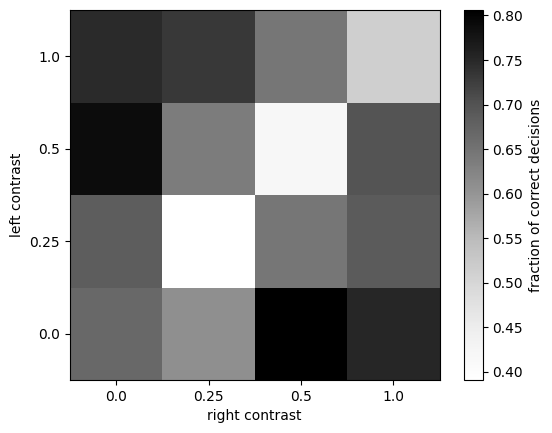

In [ ]:
contrast_values = np.unique(response_df[['contrast_left', 'contrast_right']])
heatmap_df = pd.DataFrame(np.zeros((len(contrast_values),len(contrast_values))), columns=contrast_values, index=contrast_values)


for cl, cr in product(contrast_values,contrast_values):
    df_contrast= (response_df[(response_df.contrast_left==cl) & (response_df.contrast_right==cr)])
    positive_feedback_fraction = df_contrast['feedback_type'].value_counts(normalize=True)[1]
    heatmap_df.loc[cr,cl] = positive_feedback_fraction
    print(cl, cr, len(df_contrast))


plt.imshow(heatmap_df, origin='lower', cmap='Greys')


plt.colorbar(label='fraction of correct decisions')

plt.yticks(np.arange(0.0, len(heatmap_df.index), 1), heatmap_df.index)
plt.xticks(np.arange(0.0, len(heatmap_df.columns), 1), heatmap_df.columns)
plt.xlabel('right contrast')
plt.ylabel('left contrast')
plt.show()

In [ ]:
heatmap_df

,0.00,0.25,0.50,1.00
0.00,0.667422,0.606811,0.805970,0.752119
0.25,0.683908,0.391111,0.644654,0.686324
0.50,0.787791,0.637427,0.415929,0.698758
1.00,0.747090,0.729851,0.644068,0.511312


### Q1: On average, how long does Lederberg take to make a wrong choice when there is no difference in intensities of the gratings?
  Answer: about 1s
### Q2: On average, how long does Lederberg have to wait before being rewarded for not turning the wheel when there is no difference in intensities of the gratings?
  Answer: about 2s


In [ ]:
lederberg_sessions = data[11:18]
lederberg_sessions[0].keys()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])

In [ ]:
responses = []
response_times = []
feedbacks = []
date_exps = []
feedback_times = []
contrast_diffs = []
for lederberg_session in lederberg_sessions:
  date_exps.extend([lederberg_session["date_exp"]]*len(lederberg_session["feedback_type"]))
  responses.extend(lederberg_session["response"])
  feedbacks.extend(lederberg_session["feedback_type"])
  feedback_times.extend(lederberg_session["feedback_time"])
  response_times.extend(lederberg_session["response_time"])
  contrast_diffs.extend(np.array(lederberg_session["contrast_left"]) - np.array(lederberg_session['contrast_right']))


lederberg = pd.DataFrame(data = {
    "date":date_exps,
    "response":responses,
    "feedback":feedbacks,
    "feedback_time":np.array(feedback_times).flatten(),
    "response_time":np.array(response_times).flatten(),
    "contrast_diff":np.array(contrast_diffs).flatten(),
})


In [ ]:
lederberg_zero = lederberg[lederberg['contrast_diff'] == 0.].groupby(by=['date','feedback']).agg(
    mean_response_time=('response_time', np.mean),
    mean_feedback_time=('feedback_time', np.mean),
).reset_index()

In [ ]:
lederberg_zero

,date,feedback,mean_response_time,mean_feedback_time
0,2017-12-05,-1.0,1.112888,1.132142
1,2017-12-05,1.0,1.798715,1.837009
2,2017-12-06,-1.0,1.067414,1.067414
3,2017-12-06,1.0,1.893281,1.930695
4,2017-12-07,-1.0,1.086476,1.086476
5,2017-12-07,1.0,1.971833,2.009022
6,2017-12-08,-1.0,1.193892,1.193892
7,2017-12-08,1.0,1.929718,1.968381
8,2017-12-09,-1.0,1.171635,1.171635
9,2017-12-09,1.0,1.966866,2.003946


In [ ]:
# on average, lederberg makes a wrong choice after 1 second when there is zero contrast
lederberg_zero[lederberg_zero['feedback']==-1]['mean_response_time'].mean()

1.0747234508658736

In [ ]:
lederberg_zero[lederberg_zero['feedback']==-1]['mean_feedback_time'].mean()

1.0796744440036814

In [ ]:
lederberg_zero[lederberg_zero['feedback']==1]['mean_response_time'].mean()

1.9240857988743834

In [ ]:
# on average, lederberg is supposed to have made a right choice when it doesn't turn the wheel after 2 seconds
lederberg_zero[lederberg_zero['feedback']==1]['mean_feedback_time'].mean()

1.9616317441946498

In [ ]:
df_sangee = response_df.copy()
df_sangee = df_sangee.drop(columns=['correct_turn'], axis=1)
df_sangee

def wheel_turn(df, c, b="whatever"):
    if df.contrast_left > df.contrast_right:
        return "right" + c
    elif df.contrast_left < df.contrast_right:
        return "left"+b
    else:
        return "nogo"

def response_turn(df):
    if df.response < 0:
        return "left"
    elif df.response > 0:
        return "right"
    else:
        return "nogo"

# df_sangee['correct_turn'] = df_sangee.apply(lambda x: wheel_turn(x.contrast_left, x.contrast_right), axis=1)
df_sangee['correct_turn'] = df_sangee.apply(wheel_turn, args=("bla",), b="blue", axis=1)
df_sangee['response_turn'] = df_sangee.apply(response_turn, axis=1)
df_sangee.head()

,response_interval,feedback_type,contrast_right,contrast_left,response,mouse_name,date_exp,response_turn,correct_turn
0,0.122987,1.0,0.0,1.0,1.0,Cori,2016-12-14,right,rightbla
1,0.525089,1.0,0.5,0.0,-1.0,Cori,2016-12-14,left,leftblue
2,0.124078,1.0,0.5,1.0,1.0,Cori,2016-12-14,right,rightbla
3,1.505190,1.0,0.0,0.0,0.0,Cori,2016-12-14,nogo,nogo
4,0.154765,-1.0,1.0,0.5,1.0,Cori,2016-12-14,right,leftblue


In [ ]:
mouse_idx = 11
dat = data[mouse_idx]

In [ ]:
dt = dat['bin_size']  # binning at 10 ms
spikes = dat["spks"]
n_bins = spikes.shape[-1]
timepoints = np.arange(n_bins) * dt

In [ ]:
np.unique(spikes)

array([0, 1, 2, 3, 4, 5, 6], dtype=int8)

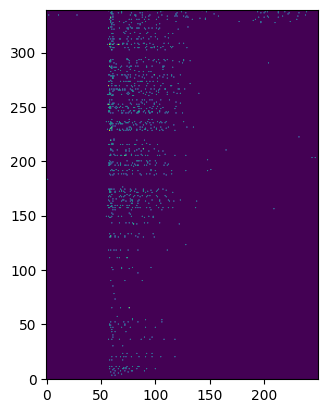

In [ ]:
neuron_idx = 4
plt.imshow(spikes[neuron_idx], origin="lower")

In [ ]:
neuron_spike_time = [timepoints[trial==1].tolist() for trial in spikes[neuron_idx]]

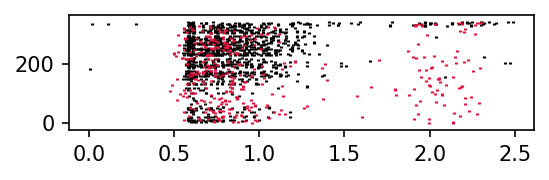

In [ ]:
fig, ax = plt.subplots(figsize=(4, 1), dpi=150)
ax.eventplot(neuron_spike_time, colors="k", linewidths=1.5, linelengths=7);
ax.eventplot(dat["response_time"], colors="crimson", linewidths=1.5, linelengths=7);

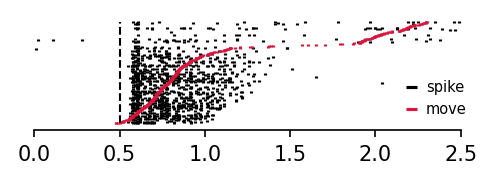

In [ ]:
response_time_order_idx = np.argsort(dat["response_time"].flatten())
fig, ax = plt.subplots(figsize=(4, 1), dpi=150)

neuron_spike_time_sorted = [neuron_spike_time[idx] for idx in response_time_order_idx]
ax.eventplot(neuron_spike_time_sorted, colors="k", linewidths=1.5, linelengths=7)
ax.eventplot(dat["response_time"][response_time_order_idx], colors="crimson", linewidths=1.5, linelengths=7);
ax.vlines(x=.5, ymin=0, ymax=len(neuron_spike_time_sorted), colors="k", linestyles="dashed", lw=1)
ax.set(yticks=[])
sns.despine(left=True, trim=True)

ax.eventplot(neuron_spike_time_sorted[0], colors="k", linewidths=1.5, linelengths=7, label="spike")
ax.eventplot(dat["response_time"][response_time_order_idx][0], colors="crimson", linewidths=1.5, linelengths=7, label="move")
lgnd = ax.legend(fontsize=7, loc="lower right", frameon=False)

# Modify the marker length for the first eventplot in legend
for handle in lgnd.legend_handles:
    xdata, ydata = handle.get_data()
    handle.set_data([10.0, 15.0], [2.45, 2.45])

In [ ]:
dfm = response_df.copy()
del dfm["correct_turn"]
dfm.head()

turn_dir = np.sign(df["contrast_left"] - df["contrast_right"])
dfm["correct_turn"] = turn_dir.apply(lambda x: ["nogo", "right", "left"][int(x)])
dfm["response_turn"] = df["response"].apply(lambda x: ["nogo", "right", "left"][int(x)])
dfm.head()

,response_interval,feedback_type,contrast_right,contrast_left,response,mouse_name,date_exp,response_turn,correct_turn
0,0.122987,1.0,0.0,1.0,1.0,Cori,2016-12-14,right,right
1,0.525089,1.0,0.5,0.0,-1.0,Cori,2016-12-14,left,left
2,0.124078,1.0,0.5,1.0,1.0,Cori,2016-12-14,right,right
3,1.505190,1.0,0.0,0.0,0.0,Cori,2016-12-14,nogo,nogo
4,0.154765,-1.0,1.0,0.5,1.0,Cori,2016-12-14,right,left


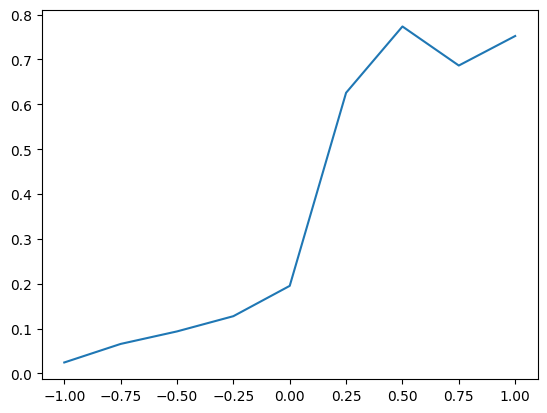

In [ ]:
dfm["left_minus_right_contrast"] = dfm["contrast_left"] - dfm["contrast_right"]
left_minus_right_contrast, turned_right = dfm.groupby("left_minus_right_contrast").apply(lambda x: sum(x.response_turn == "right")/len(x)).reset_index().values.T
plt.plot(left_minus_right_contrast, turned_right)

In [ ]:
!pip install iblatlas

Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:00<00:00, 72.79it/s]


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:00<00:00, 12.83it/s]


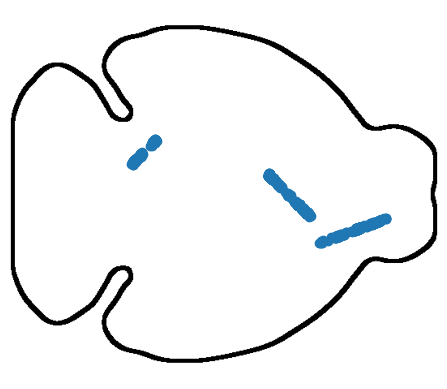

In [ ]:
from iblatlas.atlas import AllenAtlas
from skimage import feature, morphology, filters

def get_borders(x):
    x[x > 0] = 1
    x = x.astype(np.float64)
    blurred = filters.gaussian(x, sigma=10)
    edges = feature.canny(blurred, sigma=1)
    thick_edges = morphology.dilation(edges, morphology.square(5))
    return thick_edges

res = 25
brain_atlas = AllenAtlas(res_um=res)

lab = brain_atlas.label.transpose(2, 0, 1)[160]
fig, ax = plt.subplots()
ax.imshow(get_borders(lab).T[:, ::-1], cmap="gray_r", origin="lower")
ax.scatter(*dat["ccf"][:, [0, 2]].T * 5e-2)
ax.set(xticks=[], yticks=[])
for spine in ax.spines.values():
    spine.set_visible(False)

look at brainglobe - brainrender